# Fake News Detection
**Name:** Daniel Mwaka

**Group:** Group 2B

## Introduction

## Data Loading and Preprocessing

### Data Loading

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
# Import basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import NLP tools and NLTK library modules
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag
import string
import re
#import spacy

# Import scikit-learn library's classes, tools, and modules
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import joblib
from xgboost import XGBClassifier
# Import tensorflow, and keras modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dropout, Dense

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
#!pip install tensorflow

In [15]:
data = pd.read_csv("/content/drive/MyDrive/phase5/data.csv")
data.head()

,news_url,title,extracted_article_text,news_type,class
0,https://www.bustle.com/p/will-the-royals-retur...,Will 'The Royals' Return For Season 5? This St...,Entertainment With a royal wedding and a coup ...,gossip,1
1,https://www.foxnews.com/entertainment/naya-riv...,Naya Rivera refiles for divorce from Ryan Dors...,"This material may not be published, broadcast,...",gossip,1
2,https://www.unitedbypop.com/style/fashion/tayl...,Outfit ideas for Taylor Swift's Reputation Tour,United By Pop - United Kingdom. United States....,gossip,1
3,https://variety.com/2018/music/news/scott-hutc...,Scott Hutchison Dead: Frightened Rabbit Frontm...,By Robert Mitchell A body found Thursday night...,gossip,1
4,https://www.etonline.com/kate-middleton-gives-...,Kate Middleton Gives Birth to Royal Baby No. 3...,Baby No. 3 is officially here! Kate Middleton ...,gossip,1


In [16]:
# Check shape
data.shape

(16044, 5)

In [17]:
# Check duplicates
data.duplicated().sum()

np.int64(928)

In [18]:
# Drop duplicates
data.drop_duplicates(inplace=True)

In [19]:
# Confirm no duplicates
data.duplicated().sum()

np.int64(0)

In [20]:
# Inspect column attributes to check missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15116 entries, 0 to 16043
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   news_url                15116 non-null  object
 1   title                   15116 non-null  object
 2   extracted_article_text  15116 non-null  object
 3   news_type               15116 non-null  object
 4   class                   15116 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 708.6+ KB


- Data was successfully loaded and duplicates removed.
- There are no entries with missing values

### Data Preprocessing

In [21]:
# Engineer the article feature
data['article'] = data['title'] + data['extracted_article_text']
data.head()

,news_url,title,extracted_article_text,news_type,class,article
0,https://www.bustle.com/p/will-the-royals-retur...,Will 'The Royals' Return For Season 5? This St...,Entertainment With a royal wedding and a coup ...,gossip,1,Will 'The Royals' Return For Season 5? This St...
1,https://www.foxnews.com/entertainment/naya-riv...,Naya Rivera refiles for divorce from Ryan Dors...,"This material may not be published, broadcast,...",gossip,1,Naya Rivera refiles for divorce from Ryan Dors...
2,https://www.unitedbypop.com/style/fashion/tayl...,Outfit ideas for Taylor Swift's Reputation Tour,United By Pop - United Kingdom. United States....,gossip,1,Outfit ideas for Taylor Swift's Reputation Tou...
3,https://variety.com/2018/music/news/scott-hutc...,Scott Hutchison Dead: Frightened Rabbit Frontm...,By Robert Mitchell A body found Thursday night...,gossip,1,Scott Hutchison Dead: Frightened Rabbit Frontm...
4,https://www.etonline.com/kate-middleton-gives-...,Kate Middleton Gives Birth to Royal Baby No. 3...,Baby No. 3 is officially here! Kate Middleton ...,gossip,1,Kate Middleton Gives Birth to Royal Baby No. 3...


- Define a function for **_text cleaning, normalization, word tokenizing, Part-of-Speech tagging, lemmatization_** and **_removing stopwords_**, using Regular Expressions (**re**), **NLTK**, and the **string** module.

In [22]:
# nltk.download('punkt_tab')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger_eng')

In [23]:
def clean_text(text):
    text = text.lower() # Lowercase all characters
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Drop URLs
    text = re.sub(r'\[.*?\]', '', text) # Remove content enclosed by []
    text = re.sub(r'<.*?>+', '', text) # Remove content enclosed with angle brackets
    text = re.sub(r'\n', ' ', text) # Replace newline characters with space to avoid merging words

    tokens = word_tokenize(text) # Tokenize the text into words
    tagged_tokens = pos_tag(tokens) # Apply POS tagging

    lemmatizer = WordNetLemmatizer() # Instantiate lemmatizer to reduce words to their base form

    # Define helper function to map NLTK's POS tags to WordNet's tags for lemmatization
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN # Default to noun if no clear mapping

    lemmatized_words = []
    for word, tag in tagged_tokens:
        wntag = get_wordnet_pos(tag)
        lemmatized_words.append(lemmatizer.lemmatize(word, wntag))

    stop_words = set(stopwords.words('english')) # Remove stopwords
    filtered_tokens_stopwords = [word for word in lemmatized_words if word not in stop_words]

    cleaned_tokens = [re.sub(r'[^a-zA-Z]', '', word) for word in filtered_tokens_stopwords] # Remove punctuation
    cleaned_tokens = [word for word in cleaned_tokens if word] # Remove empty strings that might result from cleaning
    word_tokens = [word for word in cleaned_tokens if not word.isdigit()] # Remove digits
    final_tokens = [word for word in word_tokens if len(word) > 2] # Remove single-character and two-character words

    return final_tokens
# Apply the clean_text function to the 'article' column
data['article'] = data['article'].apply(clean_text)

In [24]:
data.head()

,news_url,title,extracted_article_text,news_type,class,article
0,https://www.bustle.com/p/will-the-royals-retur...,Will 'The Royals' Return For Season 5? This St...,Entertainment With a royal wedding and a coup ...,gossip,1,"[the, royal, return, season, story, far, overe..."
1,https://www.foxnews.com/entertainment/naya-riv...,Naya Rivera refiles for divorce from Ryan Dors...,"This material may not be published, broadcast,...",gossip,1,"[naya, rivera, refiles, divorce, ryan, dorsey,..."
2,https://www.unitedbypop.com/style/fashion/tayl...,Outfit ideas for Taylor Swift's Reputation Tour,United By Pop - United Kingdom. United States....,gossip,1,"[outfit, idea, taylor, swift, reputation, tour..."
3,https://variety.com/2018/music/news/scott-hutc...,Scott Hutchison Dead: Frightened Rabbit Frontm...,By Robert Mitchell A body found Thursday night...,gossip,1,"[scott, hutchison, dead, frightened, rabbit, f..."
4,https://www.etonline.com/kate-middleton-gives-...,Kate Middleton Gives Birth to Royal Baby No. 3...,Baby No. 3 is officially here! Kate Middleton ...,gossip,1,"[kate, middleton, give, birth, royal, baby, bo..."


### Extraploratory Data Analysis

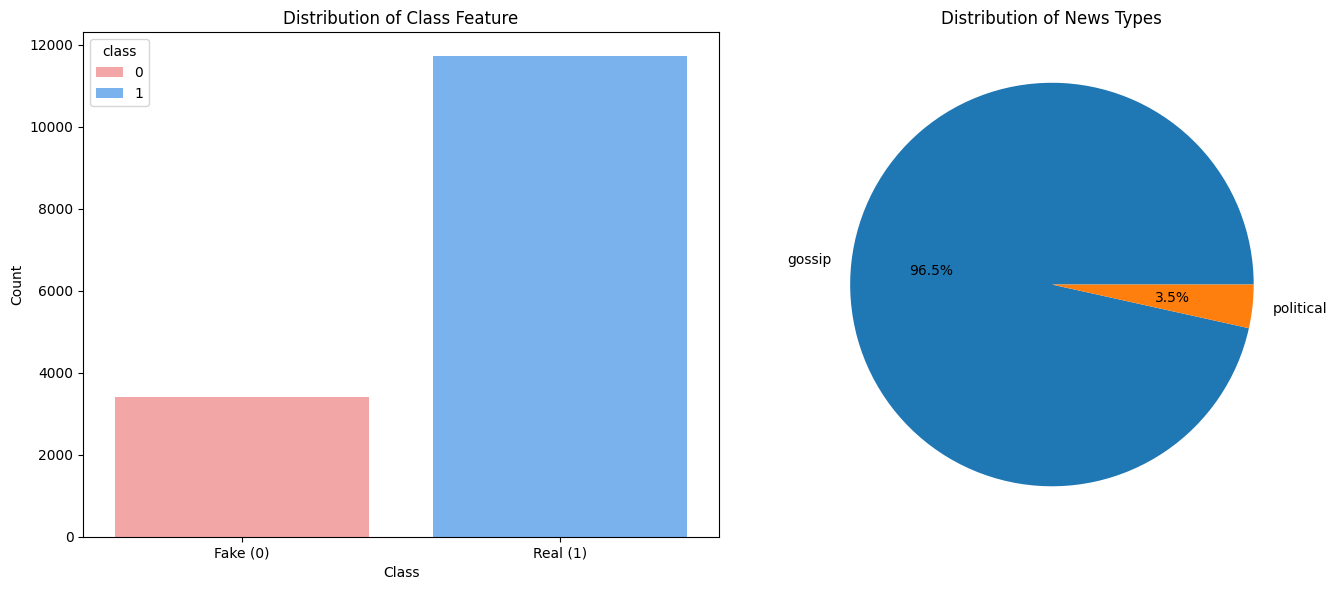

In [25]:
# Visualize Class Distribuction and News Type Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for 'class' distribution
sns.barplot(x='class', y='class', data=data, estimator=len, hue='class', palette=['#FF9999', '#66B2FF'], ax=axes[0])

# Add labels and title for the bar plot
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Class Feature')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Fake (0)', 'Real (1)'])

# Pie chart for 'news_type' distribution
news_type_counts = data['news_type'].value_counts()
axes[1].pie(news_type_counts, labels=news_type_counts.index, autopct='%1.1f%%')
axes[1].set_title('Distribution of News Types')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

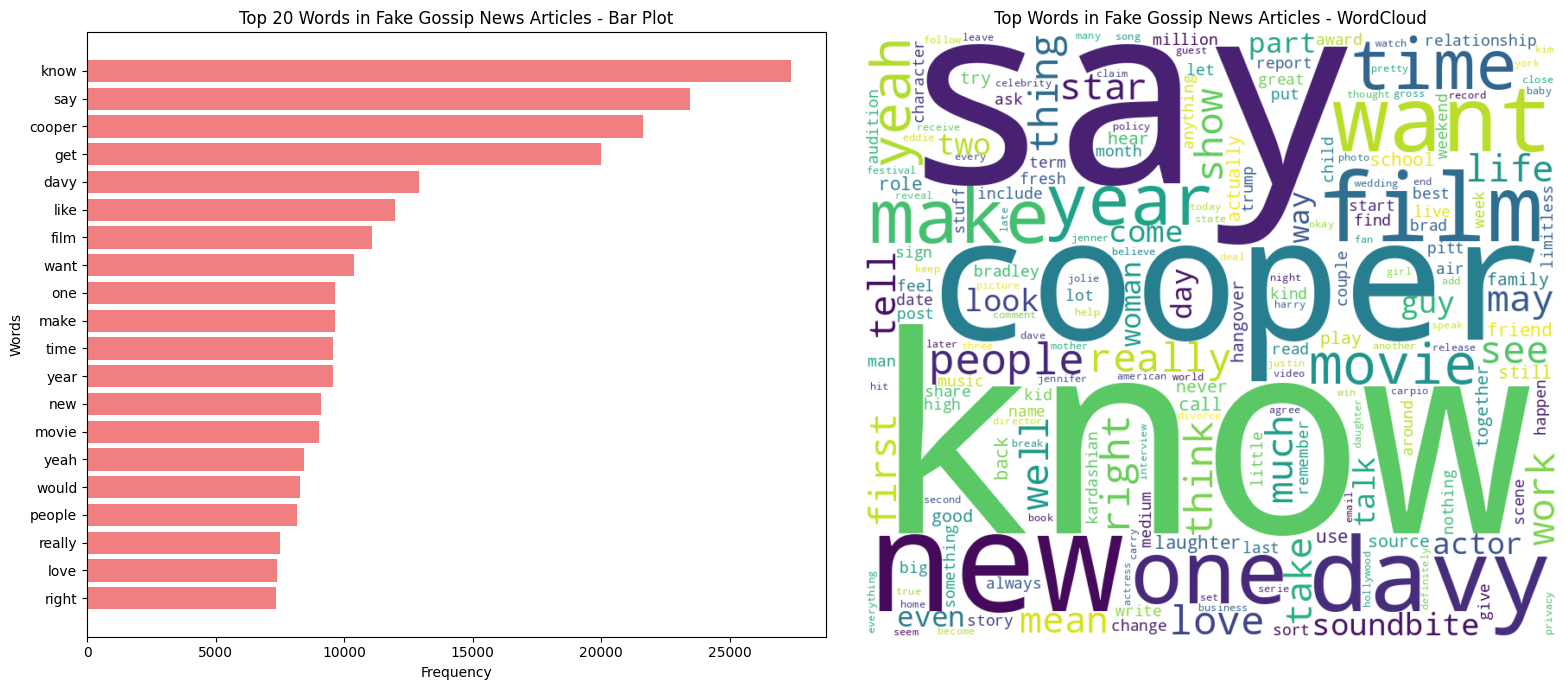

In [26]:
# Visualize the top 20 words in fake gossip news articles using a horizontal bar plot and a WordCloud
fake_gossip_news_df = data[(data['class'] == 0) & (data['news_type'] == 'gossip')]
all_fake_gossip_words = [word for sublist in fake_gossip_news_df['article'] for word in sublist]

# Count the frequency of each word
word_counts = Counter(all_fake_gossip_words)

# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Prepare data for horizontal bar plot
words_for_plot = [item[0] for item in top_20_words]
counts_for_plot = [item[1] for item in top_20_words]

# Reverse the lists to plot highest count at the top in horizontal bar plot
words_for_plot.reverse()
counts_for_plot.reverse()

# Create a single string from the list of all fake gossip words for the WordCloud
text_for_wordcloud = " ".join(all_fake_gossip_words)

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=700,
                        background_color='white',
                        collocations=False # Set to False to avoid showing common bigrams as single words
                        ).generate(text_for_wordcloud)

# Create the plots
plt.figure(figsize=(16, 7))

# Subplot 1:Horizontal Bar Plot
plt.subplot(1, 2, 1)
plt.barh(words_for_plot, counts_for_plot, color='lightcoral')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Words in Fake Gossip News Articles - Bar Plot')

# Subplot 2: WordCloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Top Words in Fake Gossip News Articles - WordCloud')
plt.tight_layout()
plt.show()

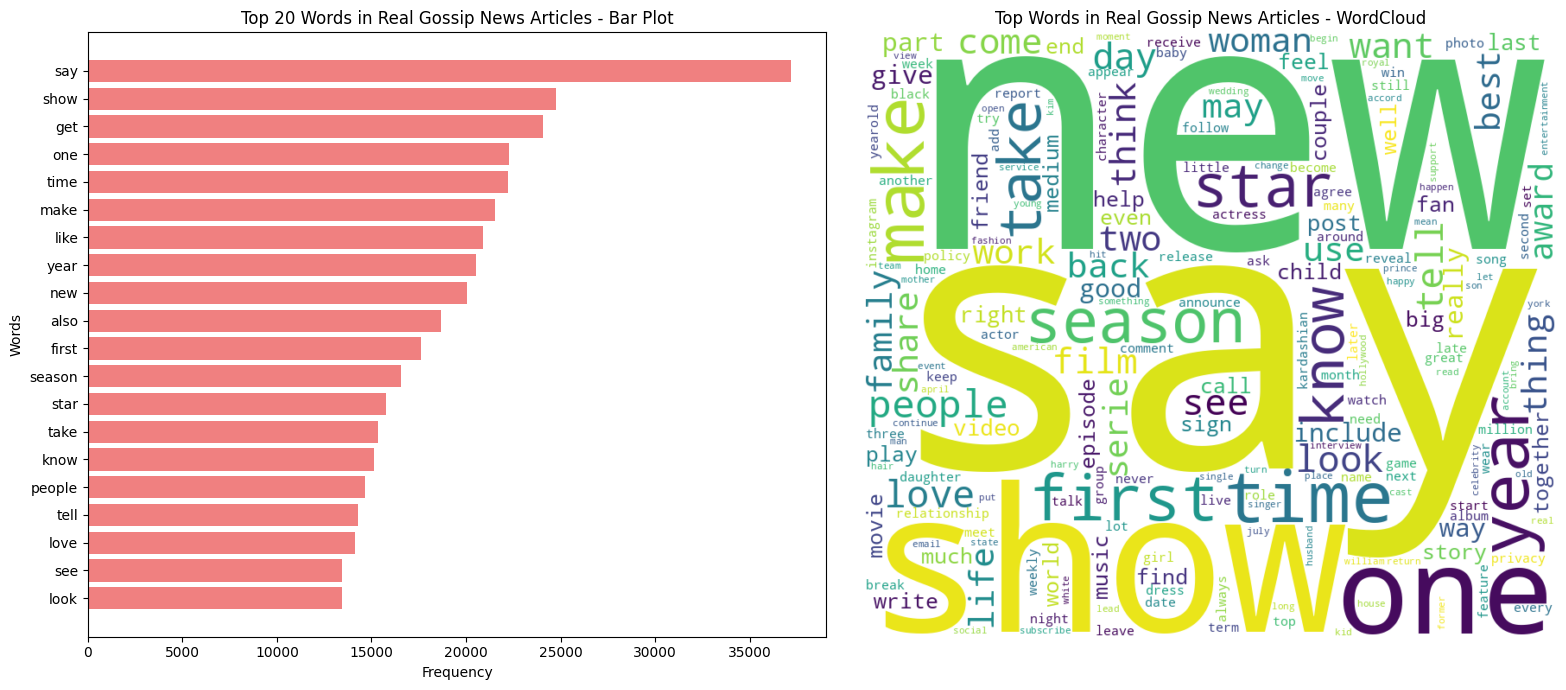

In [27]:
# Visualize the top 20 words in real gossip news articles using a horizontal bar plot and a WordCloud
real_gossip_news_df = data[(data['class'] == 1) & (data['news_type'] == 'gossip')]
all_real_gossip_words = [word for sublist in real_gossip_news_df['article'] for word in sublist]

# Count the frequency of each word
word_counts = Counter(all_real_gossip_words)

# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Prepare data for horizontal bar plot
words_for_plot = [item[0] for item in top_20_words]
counts_for_plot = [item[1] for item in top_20_words]

# Reverse the lists to plot highest count at the top in horizontal bar plot
words_for_plot.reverse()
counts_for_plot.reverse()

# Create a single string from the list of all real gossip words for the WordCloud
text_for_wordcloud = " ".join(all_real_gossip_words)

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=700,
                        background_color='white',
                        collocations=False # Set to False to avoid showing common bigrams as single words
                        ).generate(text_for_wordcloud)

# Create the plots
plt.figure(figsize=(16, 7))

# Subplot 1:Horizontal Bar Plot
plt.subplot(1, 2, 1)
plt.barh(words_for_plot, counts_for_plot, color='lightcoral')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Words in Real Gossip News Articles - Bar Plot')

# Subplot 2: WordCloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Top Words in Real Gossip News Articles - WordCloud')
plt.tight_layout()
plt.show()

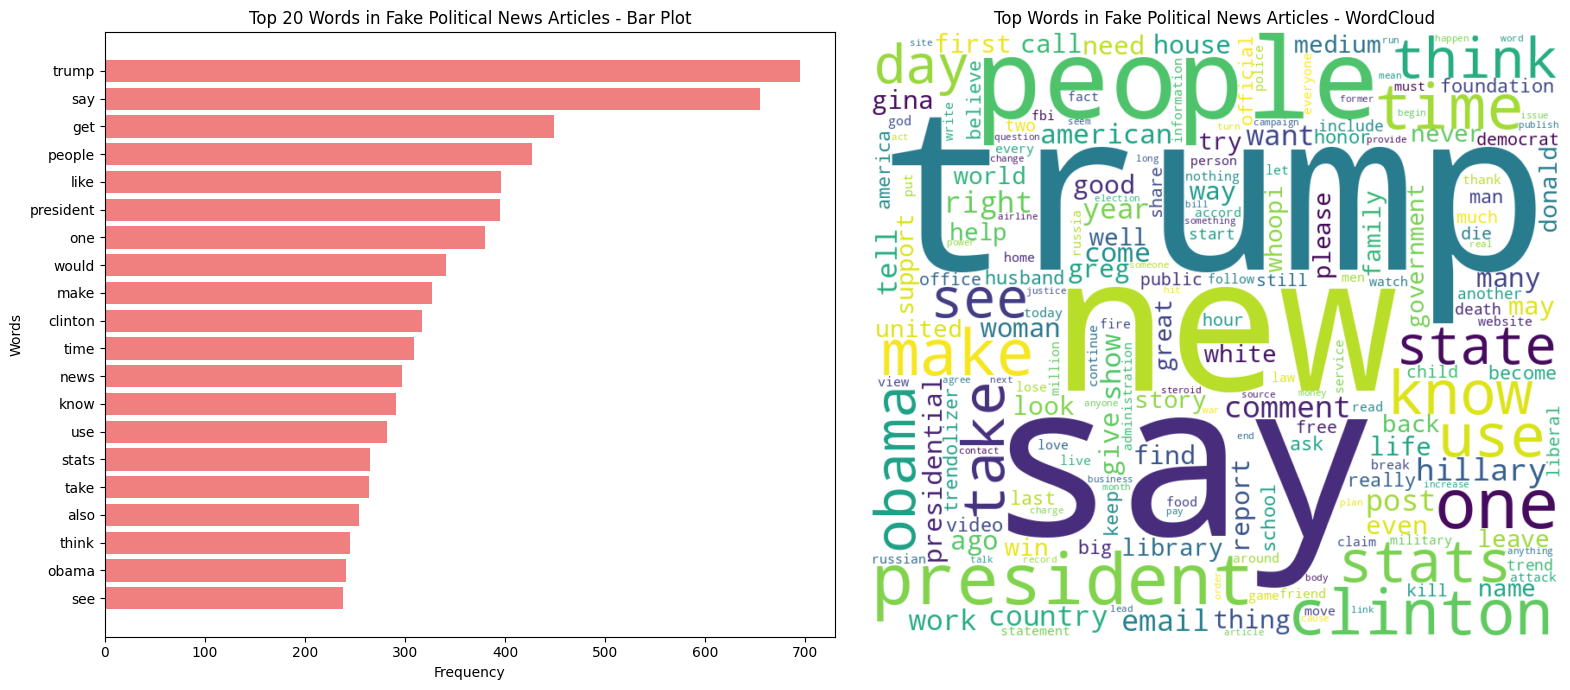

In [28]:
# Visualize the top 20 words in fake political news articles using a horizontal bar plot and a WordCloud
fake_political_news_df = data[(data['class'] == 0) & (data['news_type'] == 'political')]
all_fake_political_words = [word for sublist in fake_political_news_df['article'] for word in sublist]

# Count the frequency of each word
word_counts = Counter(all_fake_political_words)

# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Prepare data for horizontal bar plot
words_for_plot = [item[0] for item in top_20_words]
counts_for_plot = [item[1] for item in top_20_words]

# Reverse the lists to plot highest count at the top in horizontal bar plot
words_for_plot.reverse()
counts_for_plot.reverse()

# Create a single string from the list of all fake political words for the WordCloud
text_for_wordcloud = " ".join(all_fake_political_words)

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=700,
                        background_color='white',
                        collocations=False # Set to False to avoid showing common bigrams as single words
                        ).generate(text_for_wordcloud)

# Create the plots
plt.figure(figsize=(16, 7))

# Subplot 1:Horizontal Bar Plot
plt.subplot(1, 2, 1)
plt.barh(words_for_plot, counts_for_plot, color='lightcoral')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Words in Fake Political News Articles - Bar Plot')

# Subplot 2: WordCloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Top Words in Fake Political News Articles - WordCloud')
plt.tight_layout()
plt.show()

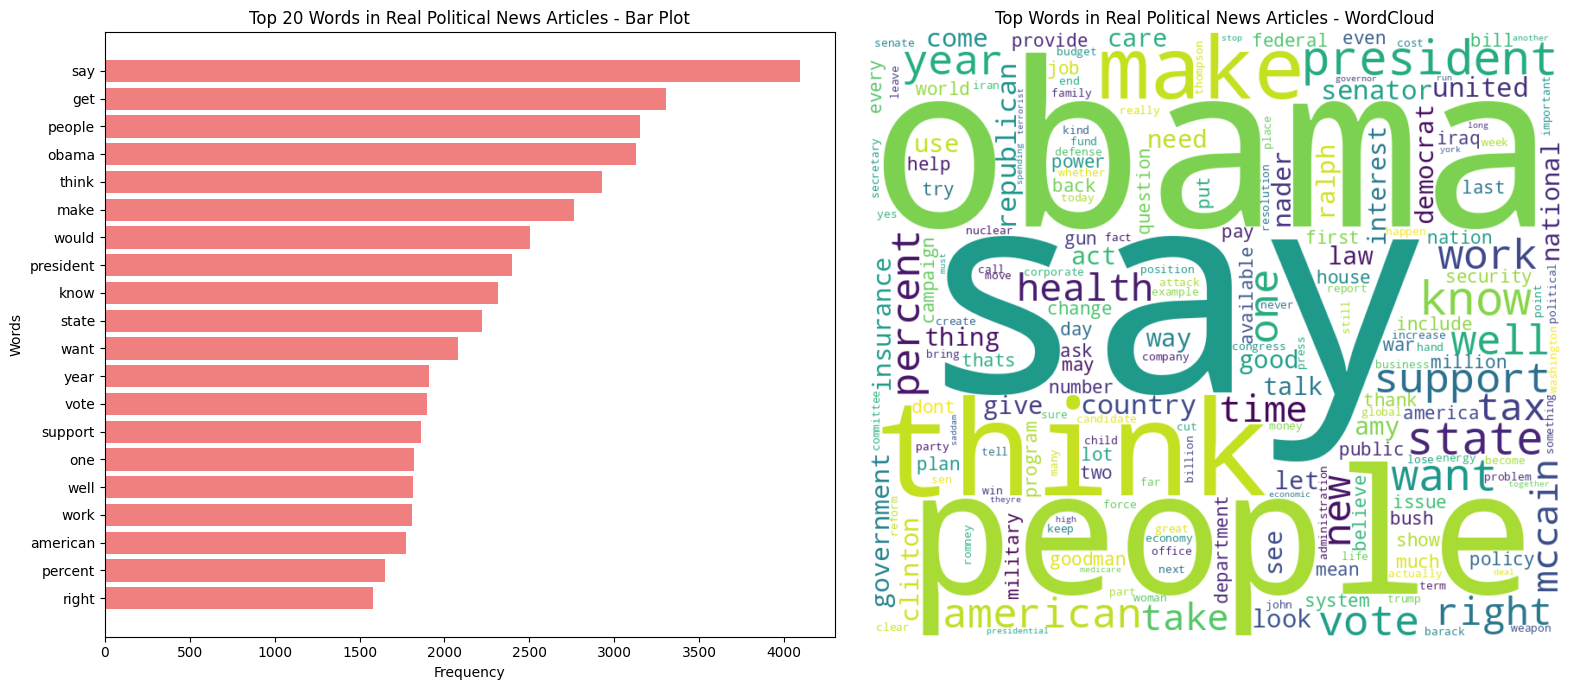

In [29]:
# Visualize the top 20 words in real political news articles using a horizontal bar plot and a WordCloud
real_political_news_df = data[(data['class'] == 1) & (data['news_type'] == 'political')]
all_real_political_words = [word for sublist in real_political_news_df['article'] for word in sublist]

# Count the frequency of each word
word_counts = Counter(all_real_political_words)

# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Prepare data for horizontal bar plot
words_for_plot = [item[0] for item in top_20_words]
counts_for_plot = [item[1] for item in top_20_words]

# Reverse the lists to plot highest count at the top in horizontal bar plot
words_for_plot.reverse()
counts_for_plot.reverse()

# Create a single string from the list of all real political words for the WordCloud
text_for_wordcloud = " ".join(all_real_political_words)

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=700,
                        background_color='white',
                        collocations=False # Set to False to avoid showing common bigrams as single words
                        ).generate(text_for_wordcloud)

# Create the plots
plt.figure(figsize=(16, 7))

# Subplot 1:Horizontal Bar Plot
plt.subplot(1, 2, 1)
plt.barh(words_for_plot, counts_for_plot, color='lightcoral')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Words in Real Political News Articles - Bar Plot')

# Subplot 2: WordCloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Top Words in Real Political News Articles - WordCloud')
plt.tight_layout()
plt.show()

## Modelling

### Objective 1: Build a Model to Predict The News Type of an Article

- Build an tune a Logistic Regression model to predict `news_type`(whether a news article categorizes under **_gossip_** or **_political_**) based on `article` (an article's tokenized text).

In [30]:
# Create a copy of the DataFrame to avoid modifying the original data
df_logistic = data.copy()

# Join tokenized article text
df_logistic["joined_text"] = df_logistic["article"].apply(lambda x: " ".join(x))

# Define Exog and Endog
X_logistic = df_logistic["joined_text"]
y_logistic = df_logistic["news_type"]

# Split data
'''First split: Training_full_logistic (80% of X) and Test_logistic (20% of X)'''
X_train_full_logistic, X_test_logistic, y_train_full_logistic, y_test_logistic = train_test_split(
    X_logistic, y_logistic, test_size=0.2, random_state=42, stratify=y_logistic)

'''Second split: Training (80% of X_train_full_logistic) and Validation (20% of X_train_full_logistic)'''
X_train_logistic, X_val_logistic, y_train_logistic, y_val_logistic = train_test_split(
    X_train_full_logistic, y_train_full_logistic, test_size=0.2, random_state=42, stratify=y_train_full_logistic)

# Print the sizes of each set
print(f"Training set size: {len(X_train_logistic)}")
print(f"Validation set size: {len(X_val_logistic)}")
print(f"Test set size: {len(X_test_logistic)}")

Training set size: 9673
Validation set size: 2419
Test set size: 3024


- Assemble pipelines for modelling a Logistic Regression model fitted with TF-IDF vectorized and count vectorized data

TF-IDF Vectorizer Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2335
           1       0.96      0.30      0.45        84

    accuracy                           0.98      2419
   macro avg       0.97      0.65      0.72      2419
weighted avg       0.97      0.98      0.97      2419


Count Vectorizer Results:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2335
           1       0.92      0.73      0.81        84

    accuracy                           0.99      2419
   macro avg       0.96      0.86      0.90      2419
weighted avg       0.99      0.99      0.99      2419



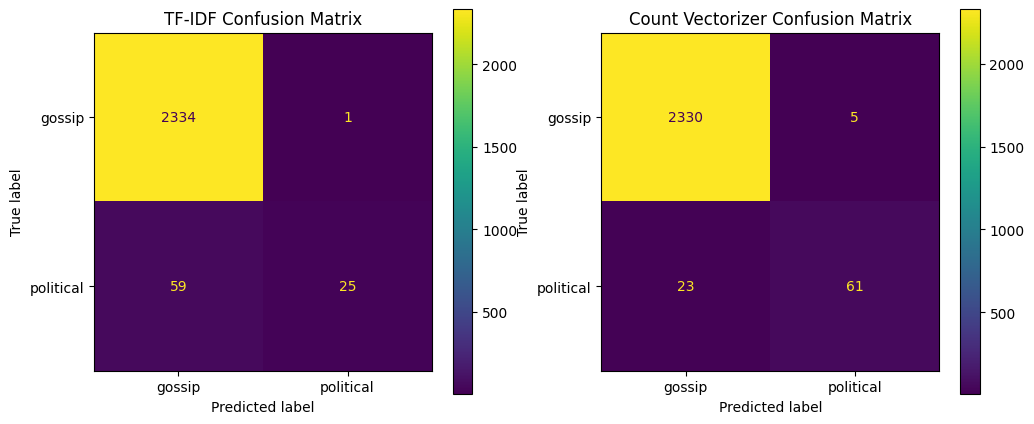

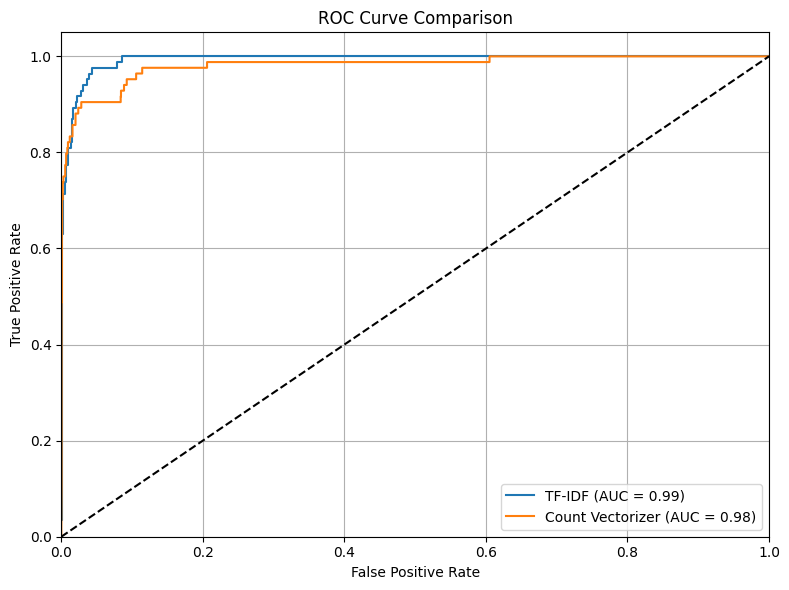

In [31]:
# Encode target labels
le = LabelEncoder()
y_train_logistic_encoded = le.fit_transform(y_train_logistic)
y_val_logistic_encoded = le.transform(y_val_logistic)

# Define pipelines
pipeline_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=200))
])

pipeline_count = Pipeline([
    ("count", CountVectorizer()),
    ("clf", LogisticRegression(max_iter=200))
])

# Fit pipelines
pipeline_tfidf.fit(X_train_logistic, y_train_logistic_encoded)
pipeline_count.fit(X_train_logistic, y_train_logistic_encoded)

# Get predictions and probabilities
y_pred_tfidf = pipeline_tfidf.predict(X_val_logistic)
y_pred_count = pipeline_count.predict(X_val_logistic)
y_prob_tfidf = pipeline_tfidf.predict_proba(X_val_logistic)[:, 1]
y_prob_count = pipeline_count.predict_proba(X_val_logistic)[:, 1]

# Print classification reports
print("TF-IDF Vectorizer Results:")
print(classification_report(y_val_logistic_encoded, y_pred_tfidf))
print("\nCount Vectorizer Results:")
print(classification_report(y_val_logistic_encoded, y_pred_count))

# Calculate ROC curves
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_val_logistic_encoded, y_prob_tfidf)
fpr_count, tpr_count, _ = roc_curve(y_val_logistic_encoded, y_prob_count)

# Calculate AUC
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)
roc_auc_count = auc(fpr_count, tpr_count)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# TF-IDF Confusion Matrix
cm_tfidf = confusion_matrix(y_val_logistic_encoded, y_pred_tfidf)
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=le.classes_)
disp_tfidf.plot(ax=ax1)
ax1.set_title('TF-IDF Confusion Matrix')

# Count Vectorizer Confusion Matrix
cm_count = confusion_matrix(y_val_logistic_encoded, y_pred_count)
disp_count = ConfusionMatrixDisplay(confusion_matrix=cm_count, display_labels=le.classes_)
disp_count.plot(ax=ax2)
ax2.set_title('Count Vectorizer Confusion Matrix')

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_tfidf, tpr_tfidf, label=f'TF-IDF (AUC = {roc_auc_tfidf:.2f})')
plt.plot(fpr_count, tpr_count, label=f'Count Vectorizer (AUC = {roc_auc_count:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()



- Select Logistic Regression model fitted with vectorized data using CountVectorization to perform Hyperparameter tuning.

In [32]:
# # Hyperparameter tuning with GridSearchCV()
# pipeline_count = Pipeline([
#     ("count", CountVectorizer()),
#     ("clf", LogisticRegression(max_iter=200))
# ])

# # Hyperparameter grid
# param_grid = {
#     "clf__C": [0.01, 0.1, 1, 10],
#     "clf__penalty": ["l2"],
#     "clf__solver": ["liblinear", "saga"]
# }

# # Run grid search
# grid_search_lr = GridSearchCV(pipeline_count, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search_lr.fit(X_train_product, y_train_product)

# # Best model and parameters
# print("Best Parameters:", grid_search_lr.best_params_)
# print("Best CV Score:", grid_search_lr.best_score_)

### Objective 2: Build a Baseline Model to Predict Class (Fake or Real) of an Article
- Build an tune an XGBoost model to predict `class`[whether a news article categorizes under **_class 0_** (**Fake**) or **_class 1_** (**Real**)] based on `article` (an article's tokenized text).

In [33]:
# Create a copy of the DataFrame to avoid modifying the original data
df_xgb = data.copy()

# Join tokenized article text
df_xgb["joined_text"] = df_xgb["article"].apply(lambda x: " ".join(x))

# Define Exog and Endog
X_xgb = df_xgb["joined_text"]
y_xgb = df_xgb["class"]

# Split data
'''First split: Training_full_xgb (80% of X) and Test_xgb (20% of X)'''
X_train_full_xgb, X_test_xgb, y_train_full_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb)

'''Second split: Training (80% of X_train_full_xgb) and Validation (20% of X_train_full_xgb)'''
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train_full_xgb, y_train_full_xgb, test_size=0.2, random_state=42, stratify=y_train_full_xgb)

# Print the sizes of each set
print(f"Training set size: {len(X_train_xgb)}")
print(f"Validation set size: {len(X_val_xgb)}")
print(f"Test set size: {len(X_test_xgb)}")

Training set size: 9673
Validation set size: 2419
Test set size: 3024


XGBoost with TF-IDF Results:
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       544
           1       0.86      0.96      0.91      1875

    accuracy                           0.85      2419
   macro avg       0.81      0.71      0.74      2419
weighted avg       0.84      0.85      0.83      2419


XGBoost with Count Vectorizer Results:
              precision    recall  f1-score   support

           0       0.79      0.45      0.57       544
           1       0.86      0.97      0.91      1875

    accuracy                           0.85      2419
   macro avg       0.82      0.71      0.74      2419
weighted avg       0.84      0.85      0.83      2419



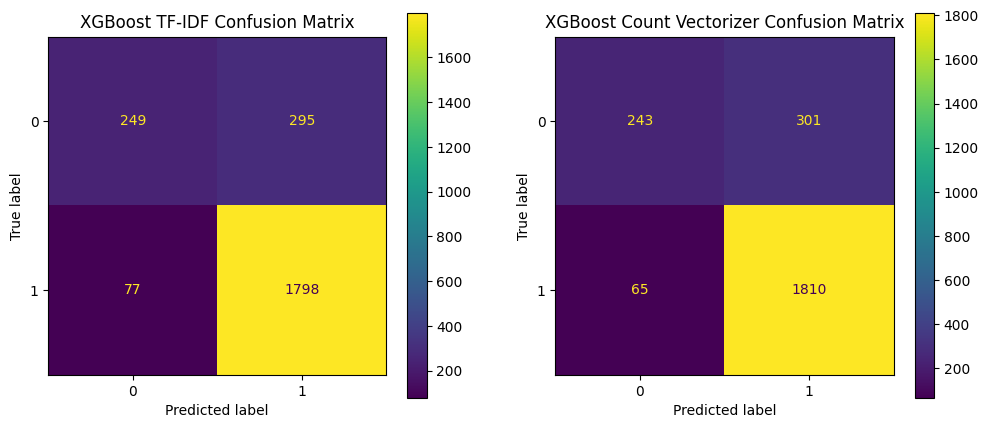

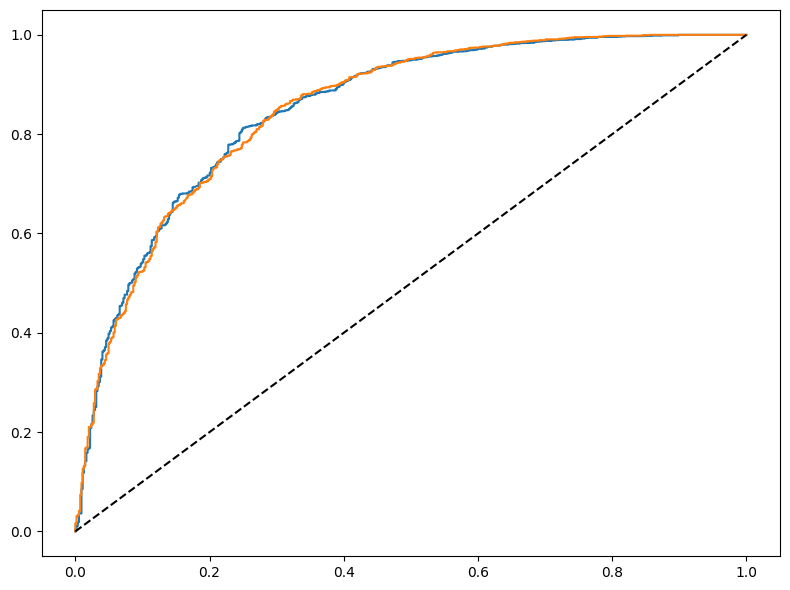

In [34]:
# Define pipelines
pipeline_xgb_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

pipeline_xgb_count = Pipeline([
    ("count", CountVectorizer()),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Fit the pipelines
pipeline_xgb_tfidf.fit(X_train_xgb, y_train_xgb)
pipeline_xgb_count.fit(X_train_xgb, y_train_xgb)

# Get predictions and probabilities
y_pred_xgb_tfidf = pipeline_xgb_tfidf.predict(X_val_xgb)
y_prob_xgb_tfidf = pipeline_xgb_tfidf.predict_proba(X_val_xgb)[:, 1]
y_pred_xgb_count = pipeline_xgb_count.predict(X_val_xgb)
y_prob_xgb_count = pipeline_xgb_count.predict_proba(X_val_xgb)[:, 1]

# Print classification reports
print("XGBoost with TF-IDF Results:")
print(classification_report(y_val_xgb, y_pred_xgb_tfidf))
print("\nXGBoost with Count Vectorizer Results:")
print(classification_report(y_val_xgb, y_pred_xgb_count))

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# TF-IDF Confusion Matrix
cm_tfidf = confusion_matrix(y_val_xgb, y_pred_xgb_tfidf)
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf)
disp_tfidf.plot(ax=ax1)
ax1.set_title('XGBoost TF-IDF Confusion Matrix')

# Count Vectorizer Confusion Matrix
cm_count = confusion_matrix(y_val_xgb, y_pred_xgb_count)
disp_count = ConfusionMatrixDisplay(confusion_matrix=cm_count)
disp_count.plot(ax=ax2)
ax2.set_title('XGBoost Count Vectorizer Confusion Matrix')

# ROC curve data
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_val_xgb, y_prob_xgb_tfidf)
fpr_count, tpr_count, _ = roc_curve(y_val_xgb, y_prob_xgb_count)

# AUC Scores
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)
roc_auc_count = auc(fpr_count, tpr_count)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_tfidf, tpr_tfidf, label=f'XGBoost TF-IDF (AUC = {roc_auc_tfidf:.2f})')
plt.plot(fpr_count, tpr_count, label=f'XGBoost Count (AUC = {roc_auc_count:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line

plt.tight_layout()
plt.show()

### Objective 3: Build an LSTM Neural Network to Predict Class (Fake or Real) of an Article
- Build an tune a Long Short-Term Memory (**LSTM**) Neural Network model to predict `class`[whether a news article categorizes under **_class 0_** (**Fake**) or **_class 1_** (**Real**)] based on `article` (an article's tokenized text).

In [35]:
# Preprocessed Data
df_lstm = data.copy()
df_lstm["joined_text"] = df_lstm["article"].apply(lambda x: " ".join(x))
X_lstm = df_lstm["joined_text"]
y_lstm = df_lstm["class"]

# Data Split
X_train_full_lstm, X_test_lstm, y_train_full_lstm, y_test_full_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, random_state=42, stratify=y_lstm)

X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(
    X_train_full_lstm, y_train_full_lstm, test_size=0.2, random_state=42, stratify=y_train_full_lstm)

# Print the sizes of each set
print(f"Training set size: {len(X_train_lstm)}")
print(f"Validation set size: {len(X_val_lstm)}")
print(f"Test set size: {len(X_test_lstm)}")

Training set size: 9673
Validation set size: 2419
Test set size: 3024


Epoch 1/5
152/152 - 42s - 277ms/step - accuracy: 0.7721 - loss: 0.5542 - val_accuracy: 0.7776 - val_loss: 0.5245
Epoch 2/5
152/152 - 38s - 252ms/step - accuracy: 0.7922 - loss: 0.4982 - val_accuracy: 0.7788 - val_loss: 0.5154
Epoch 3/5
152/152 - 38s - 250ms/step - accuracy: 0.8317 - loss: 0.4152 - val_accuracy: 0.7706 - val_loss: 0.5638
Epoch 4/5
152/152 - 38s - 248ms/step - accuracy: 0.8496 - loss: 0.3721 - val_accuracy: 0.7627 - val_loss: 0.5874
Epoch 5/5
152/152 - 37s - 246ms/step - accuracy: 0.8593 - loss: 0.3454 - val_accuracy: 0.7743 - val_loss: 0.6749
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
LSTM Model Results:
              precision    recall  f1-score   support

           0       0.49      0.12      0.20       544
           1       0.79      0.96      0.87      1875

    accuracy                           0.77      2419
   macro avg       0.64      0.54      0.53      2419
weighted avg       0.72      0.77      0.72      2419



<Figure size 600x500 with 0 Axes>

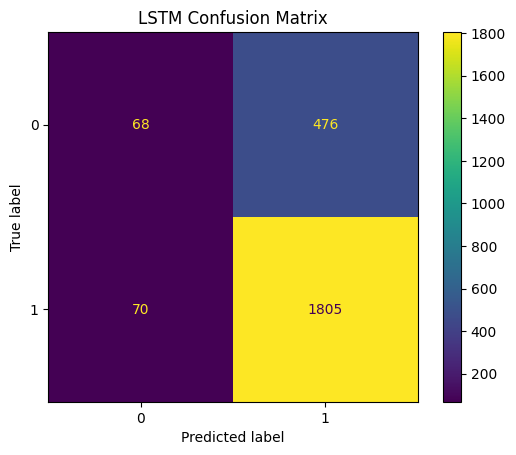

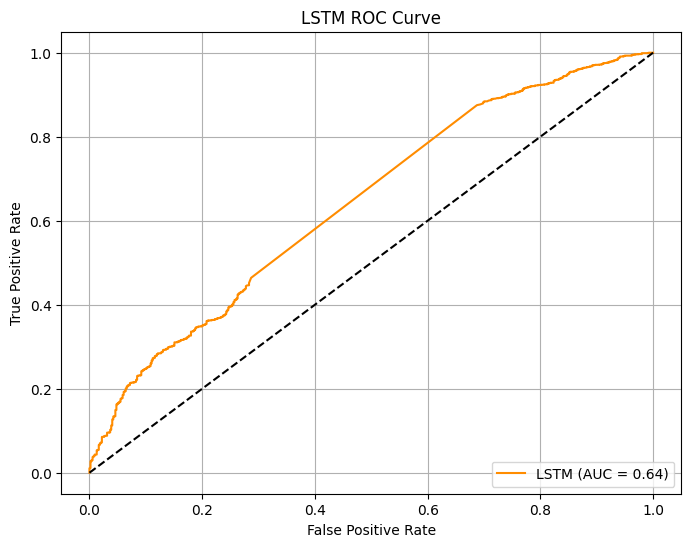

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Tokenization Parameters
vocab_size = 20000
max_length = 300
oov_tok = "<OOV>"

# Tokenize text
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_lstm)

X_train_seq = tokenizer.texts_to_sequences(X_train_lstm)
X_val_seq = tokenizer.texts_to_sequences(X_val_lstm)
X_test_seq = tokenizer.texts_to_sequences(X_test_lstm)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Convert labels to numpy arrays
y_train_arr = np.array(y_train_xgb)
y_val_arr = np.array(y_val_xgb)
y_test_arr = np.array(y_test_xgb)

# Build LSTM Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_pad, y_train_arr,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_pad, y_val_arr),
    verbose=2
)

# Predict on validation set
y_prob_lstm = model.predict(X_val_pad).ravel()
y_pred_lstm = (y_prob_lstm >= 0.5).astype(int)

# Classification Report
print("LSTM Model Results:")
print(classification_report(y_val_arr, y_pred_lstm))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm_lstm = confusion_matrix(y_val_arr, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm)
disp_lstm.plot()
plt.title('LSTM Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_val_arr, y_prob_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {roc_auc_lstm:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Objective 4: Leverage Transfer Learning to Pretrain the RoBERTa Transformer for Predicting Class (Fake or Real) of an Article
- Pretrain the RoBERTa transformer to predict `class`[whether a news article categorizes under **_class 0_** (**Fake**) or **_class 1_** (**Real**)] based on `article` (an article's tokenized text).

In [37]:
# Preprocessed Data
df_roberta = data.copy()
df_roberta["joined_text"] = df_roberta["article"].apply(lambda x: " ".join(x))
X_roberta = df_roberta["joined_text"]
y_roberta = df_roberta["class"]

# Data Split
X_train_full_roberta, X_test_roberta, y_train_full_roberta, y_test_roberta = train_test_split(
    X_roberta, y_roberta, test_size=0.2, random_state=42, stratify=y_roberta)

X_train_roberta, X_val_roberta, y_train_roberta, y_val_roberta = train_test_split(
    X_train_full_roberta, y_train_full_roberta, test_size=0.2, random_state=42, stratify=y_train_full_roberta)

# Print the sizes of each set
print(f"Training set size: {len(X_train_roberta)}")
print(f"Validation set size: {len(X_val_roberta)}")
print(f"Test set size: {len(X_test_roberta)}")

Training set size: 9673
Validation set size: 2419
Test set size: 3024


In [ ]:
#!pip install tf-keras
#!pip install datasets
#!pip install -U transformers

In [41]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer

print("Transformers is working correctly!")


Transformers is working correctly!


In [42]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("fill-mask", model="FacebookAI/xlm-roberta-base")

# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
model = AutoModelForMaskedLM.from_pretrained("FacebookAI/xlm-roberta-base")

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [44]:
from transformers import Trainer
print("Trainer import is successful")


Trainer import is successful


### BERT

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import torch

# Load BERT tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Convert train-val-test splits into Hugging Face Datasets
train_ds = Dataset.from_dict({"text": X_train_roberta.tolist(), "label": y_train_roberta.tolist()})
val_ds = Dataset.from_dict({"text": X_val_roberta.tolist(), "label": y_val_roberta.tolist()})
test_ds = Dataset.from_dict({"text": X_test_roberta.tolist(), "label": y_test_roberta.tolist()})

# Tokenize datasets
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

train_tokenized = train_ds.map(tokenize_function, batched=True)
val_tokenized = val_ds.map(tokenize_function, batched=True)
test_tokenized = test_ds.map(tokenize_function, batched=True)

# Format datasets for PyTorch Trainer
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Define metric function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": (preds == labels).mean(),
        "roc_auc": roc_auc_score(labels, pred.predictions[:, 1])
    }

# Training configuration
training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./bert_logs",
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc"
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics
)

# Train BERT
trainer.train()

# Evaluate on validation set
pred_val = trainer.predict(val_tokenized)
preds_val = np.argmax(pred_val.predictions, axis=1)
probs_val = pred_val.predictions[:, 1]

print("BERT Validation Results:")
print(classification_report(y_val_roberta, preds_val, digits=4))
print("ROC AUC:", roc_auc_score(y_val_roberta, probs_val))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9673 [00:00<?, ? examples/s]

Map:   0%|          | 0/2419 [00:00<?, ? examples/s]

Map:   0%|          | 0/3024 [00:00<?, ? examples/s]

### RoBERTa

In [ ]:
import pandas as pd
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, roc_auc_score
from datasets import Dataset
import torch
import numpy as np

# Load tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Tokenize the datasets
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

# Prepare Hugging Face datasets
train_ds = Dataset.from_dict({"text": X_train_roberta.tolist(), "label": y_train_roberta.tolist()})
val_ds = Dataset.from_dict({"text": X_val_roberta.tolist(), "label": y_val_roberta.tolist()})
test_ds = Dataset.from_dict({"text": X_test_roberta.tolist(), "label": y_test_roberta.tolist()})

# Tokenize
train_tokenized = train_ds.map(tokenize_function, batched=True)
val_tokenized = val_ds.map(tokenize_function, batched=True)
test_tokenized = test_ds.map(tokenize_function, batched=True)

# Set format for PyTorch
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": (preds == labels).mean(),
        "roc_auc": roc_auc_score(labels, pred.predictions[:, 1])
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc"
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics
)

# Fine-tune RoBERTa
trainer.train()

# Evaluate on validation set
pred_val = trainer.predict(val_tokenized)
preds_val = np.argmax(pred_val.predictions, axis=1)
probs_val = pred_val.predictions[:, 1]

print("RoBERTa Validation Results:")
print(classification_report(y_val_roberta, preds_val, digits=4))
print("ROC AUC:", roc_auc_score(y_val_roberta, probs_val))


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EvalPrediction
)
import numpy as np
import evaluate
import torch

# Step 1: Load and prepare your DataFrame
df_longformer = data.copy()
df_longformer["joined_text"] = df_longformer["article"].apply(lambda x: " ".join(x))
df_longformer = df_longformer[["joined_text", "class"]]  # Keep relevant columns
df_longformer.rename(columns={"joined_text": "text", "class": "label"}, inplace=True)

# Step 2: Train-validation-test split
train_val_df_longformer, test_df_longformer = train_test_split(df_longformer, test_size=0.2, stratify=df_longformer["label"], random_state=42)
train_df_longformer, val_df_longformer = train_test_split(train_val_df_longformer, test_size=0.2, stratify=train_val_df_longformer["label"], random_state=42)

# Step 3: Convert to Hugging Face Dataset
train_ds = Dataset.from_pandas(train_df_longformer.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df_longformer.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df_longformer.reset_index(drop=True))

# Step 4: Load tokenizer and tokenize the dataset
model_checkpoint = "allenai/longformer-base-4096"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=1024)

tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)
tokenized_test = test_ds.map(tokenize_function, batched=True)

# Step 5: Load model
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

# Step 6: Define evaluation metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

# Step 7: Training arguments
training_args = TrainingArguments(
    output_dir="./longformer-fake-news",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,  # Reduce if memory issues
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Step 8: Trainer setup
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Step 9: Train
trainer.train()

# Step 10: Evaluate on test set
trainer.evaluate(tokenized_test)


## Evaluation

### Objective 5: Compare Respective Performance to Determine Deployment Model

## Model Interpretability

## Deployment

## Conclusion and Recomendations

### Conclusion

### Recommendations

## Next Steps